<a href="https://colab.research.google.com/github/minhaz1172/Deep-Learning-with-PyTorch/blob/main/Building_ANN(overfitting_solution(optimization).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**upload kaggle josn file**

# upload kaggl.json

In [32]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"minhaz1172","key":"c20c43ca9e6e5be6fa69c912fab503c3"}'}

# check GPU Availability

In [33]:
import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Move and Set permission

In [34]:
import os
import zipfile

# Make directory and move kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set proper permissions
!chmod 600 ~/.kaggle/kaggle.json

# install kaggle package

In [35]:
!pip install -q kaggle

# Find and Download The dataset

In [36]:
!kaggle datasets download -d zalando-research/fashionmnist


Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
fashionmnist.zip: Skipping, found more recently modified local copy (use --force to force download)


# unzip the datset

In [37]:
!unzip /content/fashionmnist.zip

Archive:  /content/fashionmnist.zip
replace fashion-mnist_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

 # import necessary liabraies

In [38]:
import numpy as np
import pandas as pd
import torch

#  Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms

In [39]:
# SET random seeds for reproducibility
torch.manual_seed(42)

 # **Load trainig and testing csv file**

In [40]:
df=pd.read_csv('/content/fashion-mnist_train.csv')
df.shape

(60000, 785)

In [41]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# separate 10000 images from this csv

# show first 10 images from this


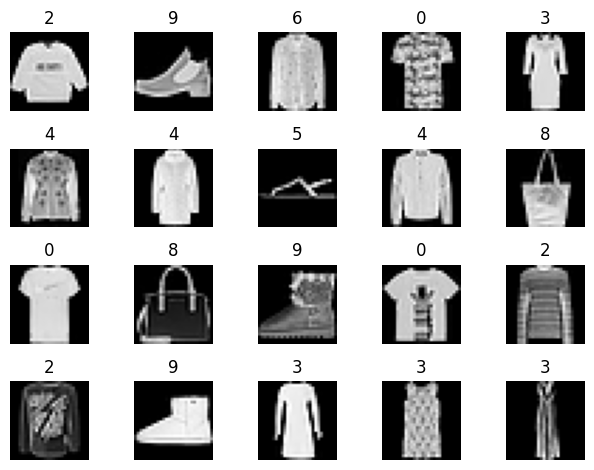

In [42]:
import matplotlib.pyplot as plt
for i in range(20):
  # first columns is label
  label=df.iloc[i,0]

  # remainging 784 values are pixel values of each image and there is 1 image = 1 row
  pixels=df.iloc[i,1:].values.reshape(28,28) # reshape to 28 by 28 images for recreating the original image. from pixel values
  # plot the image
  plt.subplot(4,5,i+1)
  plt.imshow(pixels,cmap='gray')
  plt.title(label)
  plt.axis('off')
plt.tight_layout()
plt.show()

# sepate feature and values

# iloc[:, 1:] = select: ,All rows (:),From column 1 to the last column (1:), skipping column 0,These columns represent the 784 pixel values of each image (flattened),
#.values:
# Converts the selected DataFrame part to a NumPy array,So X will have shape: (60000, 784) → 60,000 images, 784 features each

# iloc[:, 0] = select:

All rows

Only column 0, which contains the labels (e.g., 0–9 for digits)

➕ .values:
Converts the labels column to a NumPy array

So y will have shape: (60000,) → 60,000 labels

In [43]:
X=df.iloc[:,1:].values
y=df.iloc[:,0].values

# Train test split

In [44]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# SCaling the features

Each pixel value ranges from 0 to 255 (grayscale)

But neural networks work better when inputs are scaled between 0 and 1

So dividing by 255 does:

0 → 0.0

255 → 1.0

128 → 0.50196
... and so on.

This converts all pixel values into the [0, 1] range.

In [45]:
X_train=X_train/255
X_test=X_test/255

In [46]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.        ,
        0.        ]])

# Dataset Class

In [47]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)  # normalize already done
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]


# create a train dataset object

In [48]:
train_dataset=CustomDataset(X_train,y_train)


# Len of train_dataset

In [49]:
len(train_dataset)

48000

# create a test dataset

In [50]:
test_dataset=CustomDataset(X_test,y_test)

# Create train and test loader

In [51]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True)

In [52]:
len(train_loader)

1500

In [53]:
X_train.shape[1]

784

#Define Neural Network

# Several optimization technique like batch_normalization,dropout,regulrization will aplly to prevent overfitting
| Feature            | `BatchNorm1d`                         | `BatchNorm2d`               |
| ------------------ | ------------------------------------- | --------------------------- |
| Input Shape        | (N, C) or (N, C, L)                   | (N, C, H, W)                |
| Typical Use        | Fully connected layers, 1D conv, RNNs | Convolutional layers (CNNs) |
| Normalization Axis | Normalizes over N and L               | Normalizes over N, H, and W |


In [63]:
import torch.nn as nn

class ANN(nn.Module):
  def __init__(self,num_features):
    super().__init__()
    self.model=nn.Sequential(
        nn.Linear(num_features,128),
      #  nn.BatchNorm1d(128), # number of features or input of the channels
        nn.ReLU(),
        nn.Dropout(0.2),# p=0.5 means 50% neurons will ignore or dropout  during trainig
        nn.Linear(128,64),
      #  nn.BatchNorm1d(64),
        nn.ReLU(),
         nn.Dropout(0.2),
        nn.Linear(64,32),
       # nn.BatchNorm1d(32),
        nn.ReLU(),
        # nn.Dropout(0.5),
        nn.Linear(32,10)
        #Don’t apply Softmax CrossEntropyLoss internally applies LogSoftmax.
    )
  def forward(self,x):
    return self.model(x)

input_dim=X_train.shape[1]
model=ANN(input_dim)
# move to GPU
model=model.to(device)

# Loss function and optimizer update

In [64]:
import torch.optim as optim
criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
 # weight_decay is L2 regularization

# Training Loop

In [65]:
num_epochs=100
loss_history=[]
for epoch in range(num_epochs):
  for features,labels in train_loader:
    # move data to GPu
    features,labels=features.to(device),labels.to(device)
    y_pred=model(features)
    loss=criterion(y_pred,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    if (epoch + 1) % 10 == 0:
     loss_history.append(loss.item())



Streaming output truncated to the last 5000 lines.
Epoch [70/100], Loss: 0.3495
Epoch [70/100], Loss: 0.1296
Epoch [70/100], Loss: 0.1101
Epoch [70/100], Loss: 0.5670
Epoch [70/100], Loss: 0.2536
Epoch [70/100], Loss: 0.0895
Epoch [70/100], Loss: 0.1895
Epoch [70/100], Loss: 0.1808
Epoch [70/100], Loss: 0.0796
Epoch [70/100], Loss: 0.4152
Epoch [70/100], Loss: 0.2132
Epoch [70/100], Loss: 0.1107
Epoch [70/100], Loss: 0.0934
Epoch [70/100], Loss: 0.1644
Epoch [70/100], Loss: 0.1627
Epoch [70/100], Loss: 0.1865
Epoch [70/100], Loss: 0.3418
Epoch [70/100], Loss: 0.4687
Epoch [70/100], Loss: 0.1066
Epoch [70/100], Loss: 0.4396
Epoch [70/100], Loss: 0.1283
Epoch [70/100], Loss: 0.1446
Epoch [70/100], Loss: 0.0616
Epoch [70/100], Loss: 0.1693
Epoch [70/100], Loss: 0.0803
Epoch [70/100], Loss: 0.0569
Epoch [70/100], Loss: 0.3127
Epoch [70/100], Loss: 0.2429
Epoch [70/100], Loss: 0.1738
Epoch [70/100], Loss: 0.1710
Epoch [70/100], Loss: 0.1192
Epoch [70/100], Loss: 0.1903
Epoch [70/100], Loss:

# evaluation on test data

In [66]:
# set model on evaluation mode
model.eval()

ANN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=10, bias=True)
  )
)

# evaluation code

In [67]:
total=0
correct=0

with torch.no_grad():
  for features,labels in test_loader:
     features,labels=features.to(device),labels.to(device)
     y_pred=model(features)
     _,predicted=torch.max(y_pred.data,1)
     total=total+labels.shape[0]
     correct=correct+(predicted==labels).sum().item()
     accuracy=100*correct/total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 89.62%


# **evaluation on training data to check overfitting**

In [68]:
total=0
correct=0

with torch.no_grad():
  for features,labels in train_loader:   # check on trainig data
     features,labels=features.to(device),labels.to(device)
     y_pred=model(features)
     _,predicted=torch.max(y_pred.data,1)
     total=total+labels.shape[0]
     correct=correct+(predicted==labels).sum().item()
     accuracy=100*correct/total
print(f'Train Accuracy: {accuracy:.2f}%')  # 98% accuracy on traing without optimization

Train Accuracy: 96.18%
